In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
%matplotlib inline
import os
import re
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['Sarcasm_Headlines_Dataset.json']


In [2]:
df = pd.read_json('../input/Sarcasm_Headlines_Dataset.json', lines=True)
df.head()


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
df = df[['headline','is_sarcastic']]
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

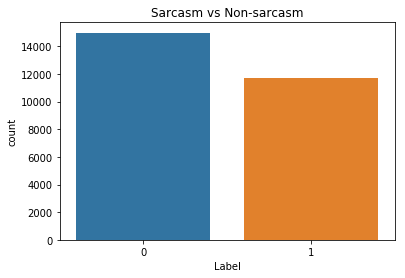

In [4]:
sns.countplot(df.is_sarcastic)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')


In [5]:
df['headline'] = df['headline'].apply(lambda x: x.lower())
df['headline'] = df['headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


In [6]:
for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['headline'].values)
X = tokenizer.texts_to_sequences(df['headline'].values)
X = pad_sequences(X)

In [7]:
Y = pd.get_dummies(df['is_sarcastic']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(17895, 29) (17895, 2)
(8814, 29) (8814, 2)


In [8]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 25, batch_size=batch_size, verbose = 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
 - 28s - loss: 0.4515 - acc: 0.7833
Epoch 2/25
 - 26s - loss: 0.3401 - acc: 0.8536
Epoch 3/25
 - 27s - loss: 0.3038 - acc: 0.8731
Epoch 4/25
 - 26s - loss: 0.2750 - acc: 0.8849
Epoch 5/25
 - 25s - loss: 0.2604 - acc: 0.8924
Epoch 6/25
 - 27s - loss: 0.2417 - acc: 0.9001
Epoch 7/25
 - 26s - loss: 0.2238 - acc: 0.9081
Epoch 8/25
 - 25s - loss: 0.2078 - acc: 0.9149
Epoch 9/25
 - 26s - loss: 0.1907 - acc: 0.9211
Epoch 10/25
 - 26s - loss: 0.1767 - acc: 0.9270
Epoch 11/25
 - 26s - loss: 0.1599 - acc: 0.9347
Epoch 12/25
 - 26s - loss: 0.1479 - acc: 0.9391
Epoch 13/25
 - 26s - loss: 0.1392 - acc: 0.9433
Epoch 14/25
 - 25s - loss: 0.1242 - acc: 0.9504
Epoch 15/25
 - 25s - loss: 0.1130 - acc: 0.9551
Epoch 16/25
 - 26s - loss: 0.1066 - acc: 0.9592
Epoch 17/25
 - 25s - loss: 0.0929 - acc: 0.9623
Epoch 18/25
 - 26s - loss: 0.0915 - acc: 0.9640
Epoch 19/25
 - 27s - loss: 0.0801 - acc: 0.9687
Epoch 20/25
 - 25s - loss: 0.0736 - acc: 0.9701
E

In [10]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.93
acc: 0.81


In [11]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("Sarcasm_acc", pos_correct/pos_cnt*100, "%")
print("Non-Sarcasm_acc", neg_correct/neg_cnt*100, "%")

Sarcasm_acc 78.43137254901961 %
Non-Sarcasm_acc 83.03464755077658 %


In [12]:
twt = ['Chowkidar hi chor hai']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=29, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("Non-sarcastic")
elif (np.argmax(sentiment) == 1):
    print("Sarcasm")

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Sarcasm


In [13]:
from keras.models import load_model
model.save('sarcasm_detection.h5')

In [14]:
!python -c 'import keras; print(keras.__version__)'

Using TensorFlow backend.
2.2.4
